# DATA REQUIREMENTS

1. Create a folder called data
2. Inside the folder 'data' create two sub folders name one folder as deer and other folder as dog. -- we need two diffrent object you can choose Dog vs Donut, lotus vs lilly etc. the folder name should be same as the class

3. collect ~20 images of dogs and save in dog folder. Rename them uniformly

4. collect ~20 images of deer and save in deer folder.
rename them uniformly.

-- No. of images has no restrictions. 

5. Zip the top folder and upload to your google drive

## Load Data

In [4]:
import os
import cv2
import numpy as np
from zipfile import ZipFile
from tqdm import tqdm

In [5]:
import shutil
if(os.path.isdir("data")):   # "data" name should be same as in folder where images are saved in the pc and loaded to drive
  shutil.rmtree("data", ignore_errors=False, onerror=None)

#Mount Google drive

In [7]:
from google.colab import drive  #mounting google drive to co lab for accessing dataset colleted in previous step "data"
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# copy the path and paste in the code below

-- change the path and folder name based on the location of your data in the drive (if necessary)

In [8]:
root_path = '/content/gdrive/MyDrive/data.zip'  #change dir to your project folder

In [9]:
# Uncompress the feature images and labels csv
def uncompress_features_labels(dir,name):
    if(os.path.isdir(name)):
        print('Data extracted')
    else:
        with ZipFile(dir) as zipf:
            zipf.extractall(name)


In [10]:
uncompress_features_labels(root_path,'data')  #once uncompressed on the left tab u must be able to see both the folders inside

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
DATADIR = "data/data"
CATEGORIES = ["deer", "dog"] # folder name as inside the data folder # os.listdir("data/data/") can be used
IMG_SIZE = 224

In [12]:
os.listdir("data/data/deer")  #to view the list of images

['d19.jpg',
 'd12.jpg',
 'd17.jpg',
 'd18.jpg',
 'd2.jpg',
 'd3.jpg',
 'd9.jpg',
 'd6.jpg',
 'd16.jpg',
 'd7.jpg',
 'd15.jpg',
 'deer_1.jpg',
 'd10.jpg',
 'd20.jpg',
 'd11.jpg',
 'd4.jpg',
 'd13.jpg',
 'd5.jpg',
 'd8.jpg',
 'd14.jpg']

In [13]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category) # os.path look in the path data/data/mime
        class_num = CATEGORIES.index(category) # 0  catergory deer =0 and dog in 1

        for img in tqdm(os.listdir(path)): #all images in the directory will be listed
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.COLOR_BGR2RGB) 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC) 
                training_data.append([new_array, class_num])
            except Exception as e:  
                pass
              
create_training_data() # output will give number of images succesfully loaded

100%|██████████| 20/20 [00:00<00:00, 698.99it/s]


In [14]:
print(len(training_data))

# center_image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
# res = cv2.resize(center_image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

40


In [15]:
print(training_data[0][0].shape) # input image size
print(training_data[0][1])

(224, 224, 3)
0


## Shuffle the data or else the order of the image may affect the perfomance of the network

Basic methods for training
To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

In [16]:
import random
random.shuffle(training_data)

In [17]:
for sample in training_data[:10]:
    print(sample[1])

1
1
0
0
1
0
0
0
0
0


In [18]:
images = []
labels = []

for features,label in training_data:
    images.append(features)
    labels.append(label)


In [19]:
X = np.array(images) # input
X = X/255
y = np.array(labels) #output

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
print(X_train.shape) # 32 images for training size 224x224x3
print(X_test.shape)
print(y_train.shape) # 
print(y_test.shape)

(32, 224, 224, 3)
(8, 224, 224, 3)
(32,)
(8,)


In [22]:
print(y_train)
print(y_test)

[0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1]
[1 1 1 1 1 0 1 1]


In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation
from tensorflow.keras.callbacks import ReduceLROnPlateau # to know at which epoch best accuracy acheived
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  


In [25]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3), data_format='channels_last'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.25)) # to avoid overfitting

model.add(Dense(84))
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax')) # 2 is the number of classes  or len(CLASS_NAMES) can be used

In [26]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# batch_size = 32
# datagen = ImageDataGenerator()
# datagen.fit(X_train)
# X_batch, y_batch = datagen.flow(X_train, y_train, batch_size=batch_size)
# model.fit_generator(datagen, samples_per_epoch=len(train), epochs=epochs)
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
1/1 [==============================] - 10s 10s/step - loss: 0.7164 - accuracy: 0.2812 - val_loss: 10.5481 - val_accuracy: 0.1250
Epoch 2/20
1/1 [==============================] - 0s 147ms/step - loss: 4.5048 - accuracy: 0.6250 - val_loss: 1.8938 - val_accuracy: 0.8750
Epoch 3/20
1/1 [==============================] - 0s 141ms/step - loss: 8.3965 - accuracy: 0.4062 - val_loss: 0.6033 - val_accuracy: 0.8750
Epoch 4/20
1/1 [==============================] - 0s 139ms/step - loss: 4.8128 - accuracy: 0.3125 - val_loss: 2.6898 - val_accuracy: 0.1250
Epoch 5/20
1/1 [==============================] - 0s 151ms/step - loss: 1.9869 - accuracy: 0.5312 - val_loss: 3.8916 - val_accuracy: 0.1250
Epoch 6/20
1/1 [==============================] - 0s 140ms/step - loss: 1.8999 - accuracy: 0.5312 - val_loss: 2.8053 - val_accuracy: 0.1250
Epoch 7/20
1/1 [==============================] - 0s 141ms/step - loss: 1.4299 - accuracy: 0.6562 - val_loss: 1.3931 - val_accuracy: 0.1250
Epoch 8/20
1/1 [====

In [28]:
dataAugmentaion = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)

# training the model
model.fit_generator(dataAugmentaion.flow(X_train, y_train, batch_size = 32),
 validation_data = (X_test, y_test), steps_per_epoch = X_train.shape[0] // 32,
 epochs = 40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/40
1/1 [==============================] - 1s 864ms/step - loss: 0.4377 - accuracy: 0.7812 - val_loss: 0.5999 - val_accuracy: 0.6250
Epoch 2/40
1/1 [==============================] - 1s 543ms/step - loss: 0.3884 - accuracy: 0.7812 - val_loss: 1.4577 - val_accuracy: 0.1250
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 0.5829 - accuracy: 0.6250 - val_loss: 0.7721 - val_accuracy: 0.3750
Epoch 4/40
1/1 [==============================] - 1s 1s/step - loss: 0.3892 - accuracy: 0.8438 - val_loss: 0.3928 - val_accuracy: 0.8750
Epoch 5/40
1/1 [==============================] - 1s 965ms/step - loss: 0.3386 - accuracy: 0.8438 - val_loss: 0.3003 - val_accuracy: 0.8750
Epoch 6/40
1/1 [==============================] - 1s 963ms/step - loss: 0.3532 - accuracy: 0.8125 - val_loss: 0.3751 - val_accuracy: 0.8750
Epoch 7/40
1/1 [==============================] - 1s 1s/step - loss: 0.3109 - accuracy: 0.9062 - val_loss: 0.5095 - val_accuracy: 0.8750
Epoch 8/40
1/1 [=============

In [29]:
predict_test = np.argmax(model.predict(X_test), axis=-1)

In [30]:
CLASS_NAMES = np.array(CATEGORIES)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_test, predict_test))
print('Classification Report')
print(classification_report(y_test, predict_test, target_names=CLASS_NAMES))

Confusion Matrix
[[1 0]
 [1 6]]
Classification Report
              precision    recall  f1-score   support

        deer       0.50      1.00      0.67         1
         dog       1.00      0.86      0.92         7

    accuracy                           0.88         8
   macro avg       0.75      0.93      0.79         8
weighted avg       0.94      0.88      0.89         8



In [32]:
# con_mat_df = pd.DataFrame(confusion_matrix(y_test, predict_test), index = CLASS_NAMES, columns = CLASS_NAMES)

con_mat_df = pd.DataFrame(confusion_matrix(y_test, predict_test), index = CLASS_NAMES, columns = CLASS_NAMES)

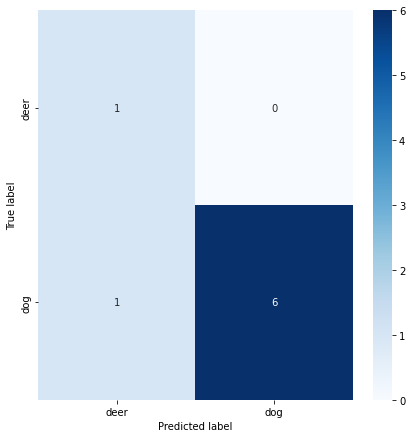

In [33]:
figure = plt.figure(figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
predict_train = np.argmax(model.predict(X_train), axis=-1)
predict_train


array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1])

In [35]:
y_train

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1])

In [36]:
# Save the model
model.save('dogdeer_model.h5')

In [ ]:
# Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model.h5')

In [57]:
model.save('dogdeer_tf_Serve', save_format='tf')


INFO:tensorflow:Assets written to: dogdeer_tf_Serve/assets
